In [1]:
import pandas as pd
import numpy as np
import collections as clt
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [3]:
df = pd.read_csv('reviews_full_v9-2.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,...,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep,neg,neu,pos
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,...,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...,0.025,0.826,0.149
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,...,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...,0.038,0.850,0.111
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,...,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...,0.026,0.771,0.202
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,...,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...,0.031,0.723,0.246
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,...,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...,0.130,0.747,0.123


In [4]:
B = nx.Graph()
userset = set()

for i,row in df.iterrows():
    if row.Score < 75:
        continue
    B.add_edge(row.User, row.Release + 'R')
    userset.add(row.User)

In [5]:
D = nx.DiGraph()

for user in userset:
    users = set()
    for album in B.adj[user]:
        users = users.union(set(B.adj[album]))
    for root in users:
        if not D.has_edge(user, root) and not D.has_edge(root, user) and root != user: #just in case two users have same set of albums
            D.add_edge(root, user)    

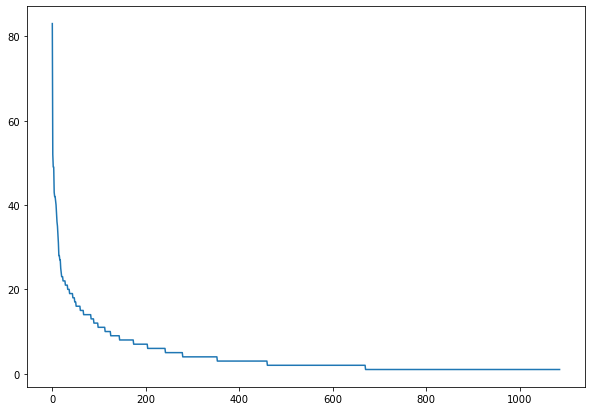

(8639, 1086)

In [6]:
roots = sorted([node for node in D.nodes() if D.in_degree(node) == 0], key = lambda x: D.out_degree(x), reverse = True)
plt.plot([D.out_degree(root) for root in roots])
plt.show()
len(userset), len(roots)

In [7]:
mp = {}

for root in roots:
    mp[root] = root
    for user in D.adj[root]:
        mp[user] = root

In [8]:
import pickle
pickle.dump(roots, open('roots.p','wb'))

In [9]:
B1 = nx.Graph()
for i,row in df.iterrows():
    if row.Score < 75:
        continue
        
    if row.User not in roots:
        B1.add_edge(row.User, row.Release + 'R')

B1.number_of_nodes(), B1.number_of_edges()

(36993, 62283)

In [10]:
G = nx.Graph()
for user in roots:
    for release in B.adj[user]:
        for node in B.adj[release]:
            if node < user: #to ensure the order, with no repeats
                if not G.has_edge(user,node):
                    G.add_edge(user, node, weight = 1, albums = {release})
                else:
                    G[user][node]['weight'] += 1
                    G[user][node]['albums'].add(release)
G.number_of_nodes(), G.number_of_edges(), nx.number_connected_components(G)

(1961, 2251, 180)

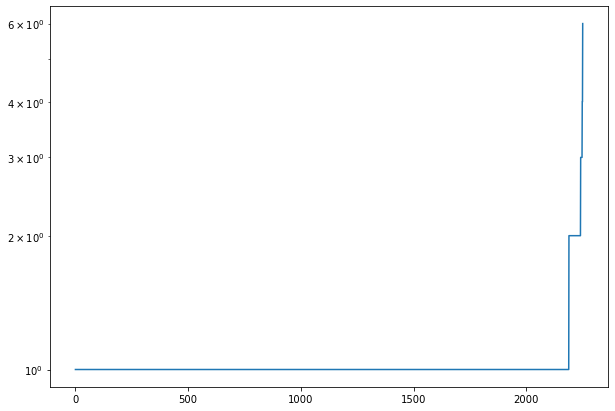

In [11]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'weight').values())))
plt.show()

In [12]:
tmp = clt.Counter([sum([D.out_degree(node)+1 for node in comp]) for comp in nx.connected_components(G)])
{k: v for k, v in sorted(tmp.items(), key=lambda item: item[0], reverse = True)}

print([len(comp) for comp in nx.connected_components(G)])

[1538, 3, 3, 2, 2, 2, 3, 2, 2, 3, 3, 6, 4, 2, 2, 3, 3, 4, 4, 2, 3, 2, 2, 2, 6, 3, 5, 2, 3, 2, 2, 2, 2, 3, 4, 3, 5, 2, 6, 4, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 5, 2, 2, 2, 4, 3, 3, 3, 2, 2, 3, 2, 2, 4, 3, 3, 2, 2, 4, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
